# Methods and Parameters for Segmentation

This notebook explores the segmentation function of `tobac` and its parameters:

- [Required Inputs](#Required-Inputs)
- [Different Thresholds](#Different-Thresholds)
- [Choosing Method and Target](#Choosing-Method-and-Target)
- [Setting a maximum Distance](#Setting-a-maximum-Distance)
- [Handling 3d-Data](#Handling-3d-Data)

We start with the usual imports:

In [1]:
import tobac
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

%matplotlib inline

import seaborn as sns

sns.set_context("talk")

## Required Inputs

To perform a segmentation we need a dataset with already detected features. Therefore, we take advantage of the `testing.make_sample_data_2D_3blobs_inv()`-utility and detect features with different thresholds:

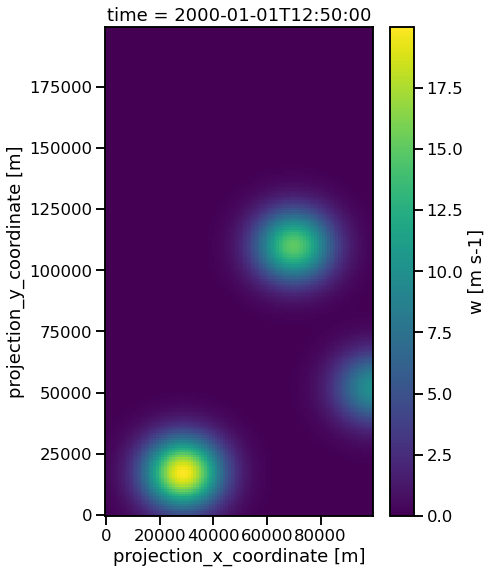

In [2]:
data = tobac.testing.make_sample_data_2D_3blobs_inv()
dxy, dt = tobac.utils.get_spacings(data)

plt.figure(figsize=(6, 9))
data.isel(time=50).plot(x="x", y="y")

In [3]:
%%capture
thresholds = [9, 14, 17]
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, thresholds, position_threshold="weighted_abs")

The resulting dataset can now be used as argument for the `segmentation()`-function. The other required inputs are the original dataset, the spacing and a threshold.

In [4]:
mask, features_mask = tobac.themes.tobac_v1.segmentation(
    features, data, dxy, threshold=9
)

<xarray.DataArray 'w' (time: 100, x: 100, y: 200)>
[2000000 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-01-01T13:39:00
  * x          (x) float64 0.0 1e+03 2e+03 3e+03 ... 9.7e+04 9.8e+04 9.9e+04
  * y          (y) float64 0.0 1e+03 2e+03 3e+03 ... 1.97e+05 1.98e+05 1.99e+05
    latitude   (x, y) float64 ...
    longitude  (x, y) float64 ...
Attributes:
    units:    m s-1


The created segments are provided as mask, which is the first returned object of the function. The second output is the features-dataset again, but with the additional *ncells*-variable, which gives us the number of datapoints belonging to the feature:

In [5]:
features_mask["ncells"][1]

<xarray.DataArray 'ncells' ()>
array(67.)
Coordinates:
    index    int64 1

Notice that this number can be deviate from the *num*-value, because watershedding works differently from just detecting the values exceeeding the threshold. For example, for the second feature *ncells* contains one additional datapoint compared to the original feature detection:

In [6]:
features_mask["num"][1]

<xarray.DataArray 'num' ()>
array(66)
Coordinates:
    index    int64 1

The created segments can be vizualized with a contour plot of tha mask:

Text(0.5, 1.0, 'Created segments')

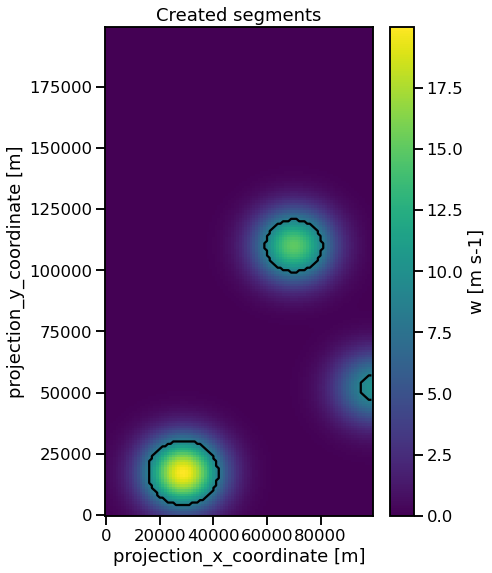

In [7]:
plt.figure(figsize=(6, 9))
data.isel(time=50).plot(x="x", y="y")
mask.isel(time=50).plot.contour(levels=[0.5], x="x", y="y", colors="k")
plt.title("Created segments")

## Different Thresholds

It is important to highlight that (in contrast to the feature detection), segmentation is only possible with **single threshold values**. Because of that, we have to call the function multiple times with different `threshold` values to explore the influence of this argument:

In [8]:
%%capture
mask_1, features_mask_1 = tobac.themes.tobac_v1.segmentation(
    features, data, dxy, threshold=9
)
mask_2, features_mask_2 = tobac.themes.tobac_v1.segmentation(
    features, data, dxy, threshold=14
)
mask_3, features_mask_3 = tobac.themes.tobac_v1.segmentation(
    features, data, dxy, threshold=17
)

To visualize the segments we can use contour-plots of the masks:

Text(0.5, 1.0, 'Segments for different threshold values')

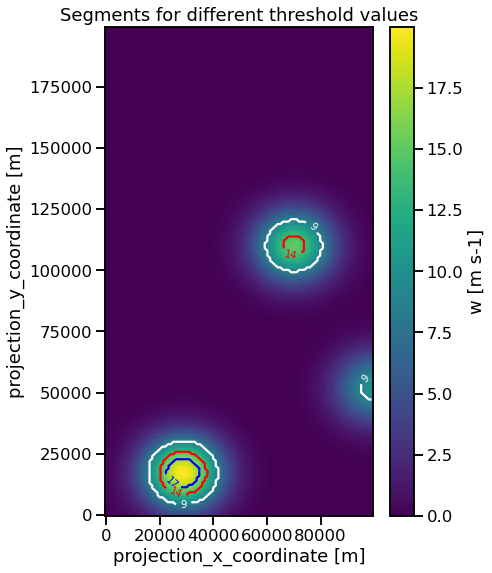

In [9]:
thresholds = [9, 14, 17]
masks = [mask_1, mask_2, mask_3]
colors = ["w", "r", "b"]

fig, ax = plt.subplots(ncols=1, figsize=(6, 9))
data.isel(time=50).plot(ax=ax, x="x", y="y")

for n, mask, color in zip(thresholds, masks, colors):

    contour = mask.isel(time=50).plot.contour(
        levels=[n], x="x", y="y", colors=color
    )
    ax.clabel(contour, inline=True, fontsize=10)

ax.set_title("Segments for different threshold values")

Obviously, a lower threshold value prodcuces a larger segment and if a feature does not exceed the value at all, no segment is associated.

## Choosing Method and Target

The segmentation uses certain techniques to associate areas or volumes to each identified feature. [Watershedding](https://en.wikipedia.org/wiki/Watershed_(image_processing)) is the default and the only implemented option at the moment, but in future realeases the method will be selected by the `method`-keyword:

In [10]:
%%capture
mask_1, features_mask_1 = tobac.themes.tobac_v1.segmentation(
    features, data, dxy, threshold=9, method="watershed"
)

Analogous to the feature detection, it is also possible to apply the segmantation to minima by changing the *target* keyword:

In [11]:
%%capture

data = -tobac.testing.make_sample_data_2D_3blobs_inv()
dxy, dt = tobac.utils.get_spacings(data)
thresholds = [-9, -14, -17]
features = tobac.themes.tobac_v1.feature_detection_multithreshold(
    data, dxy, thresholds, target="minimum"
)

mask_1, features_mask_1 = tobac.themes.tobac_v1.segmentation(
    features, data, dxy, threshold=-9, target="minimum"
)
mask_2, features_mask_2 = tobac.themes.tobac_v1.segmentation(
    features, data, dxy, threshold=-14, target="minimum"
)
mask_3, features_mask_3 = tobac.themes.tobac_v1.segmentation(
    features, data, dxy, threshold=-17, target="minimum"
)

Text(0.5, 1.0, 'Segments for different threshold values')

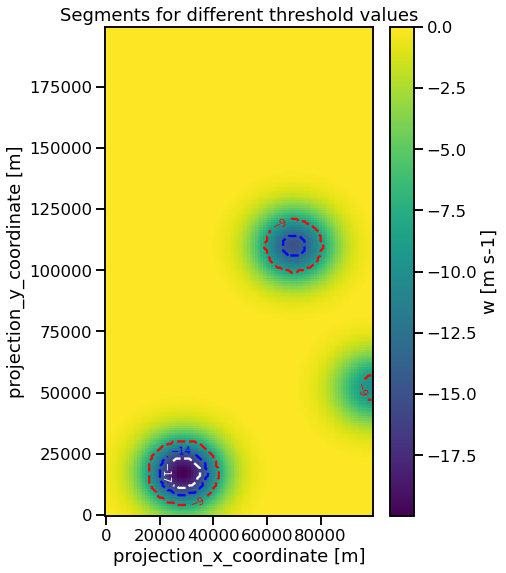

In [12]:
masks = [mask_1, mask_2, mask_3]
colors = ["r", "b", "w"]
thresholds = [-9, -14, -17]

fig, ax = plt.subplots(ncols=1, figsize=(6, 9))
data.isel(time=50).plot(ax=ax, x="x", y="y")

for n, mask, color in zip(thresholds, masks, colors):

    contour = (n * mask).isel(time=50).plot.contour(
        levels=[n], colors=color, x="x", y="y"
    )
    ax.clabel(contour, inline=True, fontsize=10)

ax.set_title("Segments for different threshold values")

## Setting a maximum Distance

Another way of determining the size of our segments is the `max_distance`-parameter. It defines a maximum distance the segment can have from the coordinates of feature (in meters). This enables us, for example, to ensure that the segments of different features do not touch each other when we use a very low threshold value:

In [13]:
%%capture

data = tobac.testing.make_sample_data_2D_3blobs_inv()
dxy, dt = tobac.utils.get_spacings(data)
thresh = 0.1

features = tobac.themes.tobac_v1.feature_detection_multithreshold(
    data, dxy, threshold=3
)
mask_0, features_0 = tobac.themes.tobac_v1.segmentation(
    features, data, dxy, threshold=thresh
)

As you can see the threshold value was set to a value of 0.1. The result is that the segments of the two upper features will touch:

Text(0.5, 1.0, 'Segments without maximum Distance')

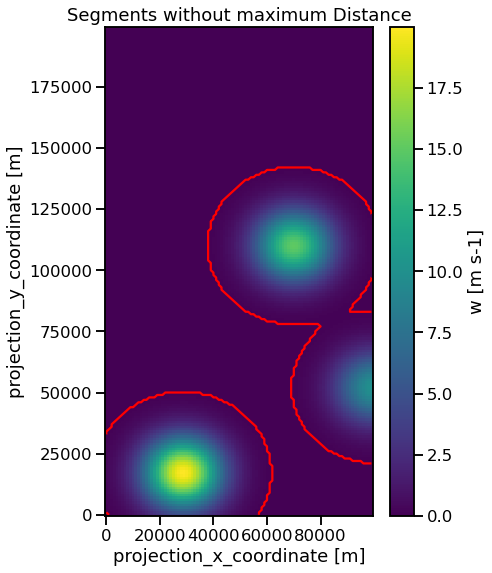

In [14]:
fig, ax = plt.subplots(figsize=(6, 9))
data.isel(time=50).plot(
    ax=ax, x="x", y="y"
)
mask_0.isel(time=50).plot.contour(
    levels=[0.5], ax=ax, colors="r", x="x", y="y"
)
ax.set_title("Segments without maximum Distance")

We can prevent this from happening by using the `max_distance` parameter to specify a maximum distance the border of the segement can have from the feature in meter:

In [15]:
%%capture

mask_1, features_mask_1 = tobac.themes.tobac_v1.segmentation(
    features, data, dxy, threshold=thresh, max_distance=40000
)
mask_2, features_mask_2 = tobac.themes.tobac_v1.segmentation(
    features, data, dxy, threshold=thresh, max_distance=20000
)
mask_3, features_mask_3 = tobac.themes.tobac_v1.segmentation(
    features, data, dxy, threshold=thresh, max_distance=5000
)

Text(0.5, 1.0, 'Segments for different maximum distances')

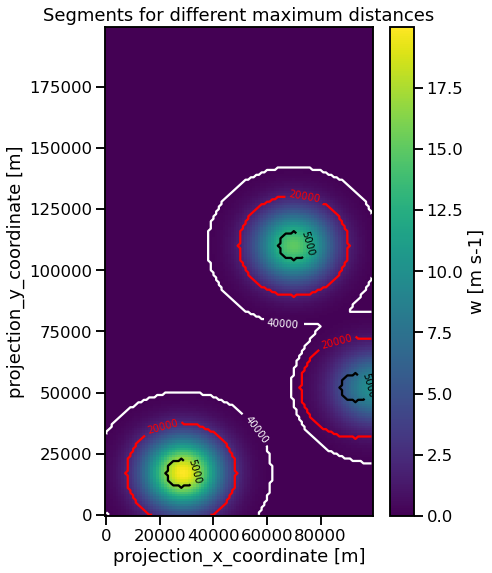

In [16]:
masks = [mask_1, mask_2, mask_3]
colors = ["w", "r", "k"]
distances = [4e4, 2e4, 5e3]

fig, ax = plt.subplots(ncols=1, figsize=(6, 9))
data.isel(time=50).plot(ax=ax, x="x", y="y")

for n, mask, color in zip(distances, masks, colors):

    contour = (n * mask).isel(time=50).plot.contour(
        levels=[n], colors=color, x="x", y="y"
    )
    ax.clabel(contour, inline=True, fontsize=10)

ax.set_title("Segments for different maximum distances")

## Handling 3d-Data

The remaining parameters `level` and `vertical_coord` are useful only for the segemtation of 3-dimensional inputs and will be covered in the notebook for 3d-data